In [31]:
import qp
import numpy as np
from scipy import linalg as sla
from scipy import special
from matplotlib import pylab as plt
%matplotlib inline
%config Completer.use_jedi = False

In [32]:
#import pdf_storage as ps
import sys, os

try:
    from mpi4py import MPI

    PLL = 'MPI'
except ImportError:
    PLL = 'SERIAL'
from astropy.io import fits as pf


In [33]:
def get_limits(ntot, Nproc, rank):
    """
    Get limits for farming an array to multiple processors

    :param int ntot: Number of objects in array
    :param int Nproc: number of processor
    :param int rank: current processor id
    :return: L1,L2 the limits of the array for given processor
    :rtype: int, int
    """
    jpproc = np.zeros(Nproc) + int(ntot / Nproc)
    for i in range(Nproc):
        if (i < ntot % Nproc): jpproc[i] += 1
    jpproc = list(map(int, jpproc))
    st = rank
    st = np.sum(jpproc[:rank]) - 1
    s0 = int(st + 1)
    s1 = int(st + jpproc[rank]) + 1
    return s0, s1

In [34]:
def create_voigt_dict(zfine, mu, Nmu, sigma, Nsigma, Nv, cut=1.e-5):
    """
    Creates a gaussian-voigt dictionary at the same resolution as the original PDF

    :param float zfine: the x-axis for the PDF, the redshift resolution
    :param float mu: [min_mu, max_mu], range of mean for gaussian
    :param int Nmu: Number of values between min_mu and max_mu
    :param float sigma: [min_sigma, max_sigma], range of variance for gaussian
    :param int Nsigma: Number of values between min_sigma and max_sigma
    :param Nv: Number of Voigt profiles per gaussian at given position mu and sigma
    :param float cut: Lower cut for gaussians

    :return: Dictionary as numpy array with shape (len(zfine), Nmu*Nsigma*Nv)
    :rtype: float

    """

    zmid = np.linspace(mu[0], mu[1], Nmu)
    sig = np.linspace(sigma[0], sigma[1], Nsigma)
    gamma = np.linspace(0, 0.5, Nv)
    NA = Nmu * Nsigma * Nv
    Npdf = len(zfine)
    A = np.zeros((Npdf, NA))
    kk = 0
    for i in range(Nmu):
        for j in range(Nsigma):
            for k in range(Nv):
                #pdft = 1. * exp(-((zfine - zmid[i]) ** 2) / (2.*sig[j]*sig[j]))
                pdft = voigt(zfine, zmid[i], sig[j], sig[j] * gamma[k])
                pdft = np.where(pdft >= cut, pdft, 0.)
                A[:, kk] = pdft / sla.norm(pdft)
                kk += 1
    return A


def reconstruct_pdf_v(index, vals, zfine, mu, Nmu, sigma, Nsigma, Nv, cut=1.e-5):
    """
    This function reconstruct the pdf from the indices and values and parameters used to create the dictionary with
    Gaussians and Voigt profiles

    :param int index: List of indices in the dictionary for the selected bases
    :param float vals: values or coefficients corresponding to the listed indices
    :param float zfine: redshift values from the original pdf or used during the sparse representation
    :param float mu: [min_mu, max_mu] values used to create the dictionary
    :param int Nmu: Number of mu values used to create the dictionary
    :param float sigma: [min_sigma, mas_sigma] sigma values used to create the dictionary
    :param int Nsigma: Number of sigma values
    :param int Nv: Number of Voigt profiles used to create dictionary
    :param float cut: cut threshold when creating the dictionary

    :return: the pdf normalized so it sums to one
    """

    zmid = np.linspace(mu[0], mu[1], Nmu)
    sig = np.linspace(sigma[0], sigma[1], Nsigma)
    gamma = np.linspace(0, 0.5, Nv)
    pdf = np.zeros(len(zfine))
    for kk in range(len(index)):
        i = int(index[kk] / (Nsigma * Nv))
        j = int((index[kk] % (Nsigma * Nv)) / Nv)
        k = int(index[kk] % (Nsigma * Nv)) % Nv
        pdft = voigt(zfine, zmid[i], sig[j], sig[j] * gamma[k])
        pdft = np.where(pdft >= cut, pdft, 0.)
        pdft = pdft / sla.norm(pdft)
        pdf += pdft * vals[kk]
        #pdf = np.where(pdf >= cut, pdf, 0)
    pdf = np.where(np.greater(pdf, max(pdf) * 0.005), pdf, 0.)
    if sum(pdf) > 0: pdf = pdf / sum(pdf)
    return pdf


def reconstruct_pdf_int(long_index, header, cut=1.e-5):
    """
    This function reconstruct the pdf from the integer indices only and the parameters used to create the dictionary
    with Gaussians and Voigt profiles

    :param int long_index: List of indices including coefficients (32bits integer array)
    :param dict header: Dictionary of the fits file header with information used to create dictionary and sparse indices
    :param float cut: cut threshold when creating the dictionary

    :return: the pdf normalized so it sums to one
    """

    Ncoef = header['Ncoef']
    zfine = header['z']
    mu = header['mu']
    Nmu = header['Nmu']
    sigma = header['sig']
    Nsigma = header['Nsig']
    Nv = header['Nv']

    VALS = np.linspace(0, 1, Ncoef)
    dVals = VALS[1] - VALS[0]
    sp_ind = np.array(list(map(get_N, long_index)))
    spi = sp_ind[:, 0]
    Dind2 = sp_ind[:, 1]
    vals = spi * dVals
    ####
    vals[0]=1.
    ####
    rep_pdf = reconstruct_pdf_v(Dind2, vals, zfine, mu, Nmu, sigma, Nsigma, Nv)
    return rep_pdf

def voigt(x, x_mean, sigma, gamma):
    """
     Voigt profile
     V(x,sig,gam) = Re(w(z)), w(z) Faddeeva function
     z = (x+j*gamma)/(sigma*sqrt(2))

     :param float x: the x-axis values (redshift)
     :param float x_mean: Mean of the gaussian or Voigt
     :param float sigma: Sigma of the original Gaussian when gamma=0
     :param float gamma: Gamma parameter for the Lorentzian profile (Voigt)

     :return: The real values of the Voigt profile at points x
     """

    x = x - x_mean
    z = (x + 1j * gamma) / (np.sqrt(2.) * sigma)
    It = special.wofz(z).real
    return It


def combine_int(Ncoef, Nbase):
    """
    combine index of base (up to 62500 bases) and value (16 bits integer with sign) in a 32 bit integer
    First half of word is for the value and second half for the index

    :param int Ncoef: Integer with sign to represent the value associated with a base, this is a sign 16 bits integer
    :param int Nbase: Integer representing the base, unsigned 16 bits integer
    :return: 32 bits integer
    """
    return (Ncoef << 16) | Nbase


def get_N(longN):
    """
    Extract coefficients fro the 32bits integer,
    Extract Ncoef and Nbase from 32 bit integer
    return (longN >> 16), longN & 0xffff

    :param int longN: input 32 bits integer

    :return: Ncoef, Nbase both 16 bits integer
    """
    return (longN >> 16), (longN & (2 ** 16 - 1))

def sparse_basis(dictionary, query_vec, n_basis, tolerance=None):
    """
    Compute sparse representation of a vector given Dictionary  (basis)
    for a given tolerance or number of basis. It uses Cholesky decomposition to speed the process and to
    solve the linear operations adapted from Rubinstein, R., Zibulevsky, M. and Elad, M., Technical Report - CS
    Technion, April 2008

    :param float dictionary: Array with all basis on each column, must has shape (len(vector), total basis) and each column must have euclidean l-2 norm equal to 1
    :param float query_vec: vector of which a sparse representation is desired
    :param int n_basis: number of desired basis
    :param float tolerance: tolerance desired if n_basis is not needed to be fixed, must input a large number for n_basis to assure achieving tolerance

    :return: indices, values (2 arrays one with the position and the second with the coefficients)
    """

    a_n = np.zeros(dictionary.shape[1])
    machine_eps = np.finfo(dictionary.dtype).eps
    alpha = np.dot(dictionary.T, query_vec)
    res = query_vec
    idxs = np.arange(dictionary.shape[1])  # keeping track of swapping
    L = np.zeros((n_basis, n_basis), dtype=dictionary.dtype)
    L[0, 0] = 1.

    for n_active in range(n_basis):
        lam = np.argmax(abs(np.dot(dictionary.T, res)))
        if lam < n_active or alpha[lam] ** 2 < machine_eps:
            n_active -= 1
            break
        if n_active > 0:
            # Updates the Cholesky decomposition of dictionary
            L[n_active, :n_active] = np.dot(dictionary[:, :n_active].T, dictionary[:, lam])
            sla.solve_triangular(L[:n_active, :n_active], L[n_active, :n_active], lower=True, overwrite_b=True)
            v = sla.norm(L[n_active, :n_active]) ** 2
            if 1 - v <= machine_eps:
                print("Selected basis are dependent or normed are not unity")
                break
            L[n_active, n_active] = np.sqrt(1 - v)
        dictionary[:, [n_active, lam]] = dictionary[:, [lam, n_active]]
        alpha[[n_active, lam]] = alpha[[lam, n_active]]
        idxs[[n_active, lam]] = idxs[[lam, n_active]]
        # solves LL'x = query_vec as a composition of two triangular systems
        gamma = sla.cho_solve((L[:n_active + 1, :n_active + 1], True), alpha[:n_active + 1], overwrite_b=False)
        res = query_vec - np.dot(dictionary[:, :n_active + 1], gamma)
        if tolerance is not None and sla.norm(res) ** 2 <= tolerance:
            break
    a_n[idxs[:n_active + 1]] = gamma
    del dictionary
    #return a_n
    return idxs[:n_active + 1], gamma


In [35]:
if PLL == 'MPI':
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
else:
    size = 1
    rank = 0

In [36]:
filein = '/home/cohen/lsst/codes/pipelines/photoz/SparsePz/CFHTLens_sample.P.npy'
#FORMAT FILE, EACH ROW IS THE PDF FOR EACH GALAXY, LAST ROW IS THE REDSHIFT POSITION
P = np.load(filein)
Ntot = len(P) - 1 #last row is redshift
z = P[-1]

ens = qp.read('qp_test_ensemble.hdf5')
z = ens.metadata()['xvals'][0]
ens_red = ens[np.arange(100)]
P = ens_red.objdata()['yvals']
Ntot = len(P)

In [37]:
if rank == 0:
    print("Total Galaxies = ", Ntot)
dz = z[1] - z[0]
if rank == 0:
    print('dz = ', dz)

mu = [min(z), max(z)]
Nmu = 250 #len(z)
max_sig = (max(z) - min(z)) / 12.
min_sig = dz / 6.
Nsig = int(np.ceil(2. * (max_sig - min_sig) / dz))
sig = [min_sig, max_sig]
Nv = 3
Nsig = 80
NA = Nmu * Nsig * Nv

if rank == 0:
    print('Nmu, Nsig, Nv = ', '[', Nmu, ',', Nsig, ',', Nv, ']')
    print('Total bases in dictionary', NA)

#Create dictionary
if rank == 0:
    print('Creating Dictionary...')
A = create_voigt_dict(z, mu, Nmu, sig, Nsig, Nv)
bigD = {}

toler = 1.e-10
Nsparse = 20
Ncoef = 32001
AA = np.linspace(0, 1, Ncoef)
Da = AA[1] - AA[0]

if rank == 0:
    print('Nsparse (number of bases) = ', Nsparse)

bigD['z'] = z
bigD['mu'] = mu
bigD['sig'] = sig
bigD['dims'] = [Nmu, Nsig, Nv, Ncoef]
bigD['N_SPARSE'] = Nsparse
bigD['Ntot'] = Ntot

if rank == 0:
    for i in range(size):
        Xs_0, Xs_1 = get_limits(Ntot, size, i)
        print(Xs_0, ' ', Xs_1, ' -------------> to core ', i)

s0, s1 = get_limits(Ntot, size, rank)
P = P[s0:s1]

if rank == 0:
    print('Creating Sparse representation...')

for ik in range(Ntot):
    k = s0 + ik
    bigD[k] = {}
    try:
        pdf0 = P[ik]
    except:
        continue
    if np.sum(pdf0) > 0:
        pdf0 /= np.sum(pdf0)
    else:
        continue
        
    Dind, Dval = sparse_basis(A, pdf0, Nsparse)
    if len(Dind) <= 1: continue
    bigD[k]['sparse'] = [Dind, Dval]
    if max(Dval) > 0:
        dval0=Dval[0]
        Dvalm = Dval / np.max(Dval)
        index = np.array(list(map(round, (Dvalm / Da))), dtype='int')
        index0=int(round(dval0/Da))
        index[0]=index0
    else:
        index = np.zeros(len(Dind), dtype='int')
    bigD[k]['sparse_ind'] = np.array(list(map(combine_int, index, Dind)))

    #swap back columns
    A[:, [Dind]] = A[:, [np.arange(len(Dind))]]

print('Done with processor: ', rank)
if PLL == 'MPI': comm.Barrier()

if PLL == 'MPI':
    if rank == 0:
        for srank in np.arange(1, size):
            temp = comm.recv(source=srank, tag=srank * 2)
            bigD.update(temp)
            del temp
    else:
        comm.send(bigD, dest=0, tag=rank * 2)
    comm.Barrier()


if PLL == 'MPI':
    comm.Barrier()
    MPI.Finalize()


Total Galaxies =  100
dz =  0.01
Nmu, Nsig, Nv =  [ 250 , 80 , 3 ]
Total bases in dictionary 60000
Creating Dictionary...
Nsparse (number of bases) =  20
0   100  -------------> to core  0
Creating Sparse representation...
Done with processor:  0


In [38]:
ALL = np.zeros((Ntot, Nsparse), dtype='int')
for i in range(Ntot):
    if i in bigD:
        idd = bigD[i]['sparse_ind']
        ALL[i, 0:len(idd)] = idd

In [39]:
meta = {}
#head['N_TOT'] = Ntot
meta['z'] = z
meta['Nmu'] = bigD['dims'][0]
meta['Nsig'] = bigD['dims'][1]
meta['Nv'] = bigD['dims'][2]
meta['Ncoef'] = bigD['dims'][3]
meta['N_SPARSE'] = bigD['N_SPARSE']
meta['mu'] = bigD['mu']
meta['sig'] = bigD['sig']

In [29]:
#Now build a voigt representation based on the sparse index and plot it
k=70
rep_pdf = reconstruct_pdf_int(ALL[k], meta)

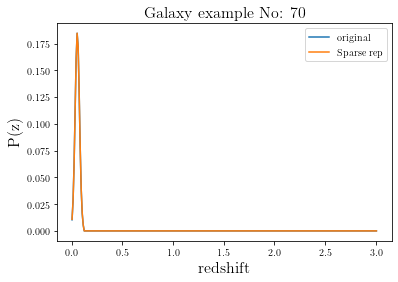

In [30]:
plt.plot(z, P[k] / sum(P[k]), label='original')
plt.plot(z, rep_pdf, label='Sparse rep')
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.legend(loc=0)
title = 'Galaxy example No: %d' % k
plt.title(title);


In [9]:
#writing to a fits file
if False:
    print('Writing fits file (example_out.fits)')

    head = pf.Header()
    head['N_TOT'] = Ntot
    head['N_MU'] = bigD['dims'][0]
    head['N_SIGMA'] = bigD['dims'][1]
    head['N_VOIGT'] = bigD['dims'][2]
    head['N_COEF'] = bigD['dims'][3]
    head['N_SPARSE'] = bigD['N_SPARSE']
    head['MU1'] = bigD['mu'][0]
    head['MU2'] = bigD['mu'][1]
    head['SIGMA1'] = bigD['sig'][0]
    head['SIGMA2'] = bigD['sig'][1]

    col1 = pf.Column(name='redshift', format='E', array=bigD['z'])
    fmt = '%dJ' % bigD['N_SPARSE']
    col2 = pf.Column(name='Sparse_indices', format=fmt, array=ALL)
    table1 = pf.BinTableHDU.from_columns(pf.ColDefs([col1]))
    table2 = pf.BinTableHDU.from_columns(pf.ColDefs([col2]))
    prihdu = pf.PrimaryHDU(header=head)
    hdulist = pf.HDUList([prihdu, table1, table2])
    hdulist.writeto('example_out.fits', clobber=True)
